In [1]:
%%capture
!pip install transformers==4.31.0  # version specific 

In [1]:
from lavis.models import model_zoo

import re
import torch
from torch import nn
from torchvision import transforms

import json

from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

/opt/conda/envs/pytorch/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [3]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess, load_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
model, vision_processer, lang_processer = load_model_and_preprocess(name="blip2", model_type="pretrain")

In [6]:
model.to(device)

Blip2Qformer(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )


In [7]:
vision_processer
# language_process has no use; rather, tokenize text by model.tokenizer

{'train': <lavis.processors.blip_processors.BlipImageTrainProcessor at 0x7f338e4277f0>,
 'eval': <lavis.processors.blip_processors.BlipImageEvalProcessor at 0x7f338e3fafe0>}

In [8]:
vision_encoder = model.visual_encoder

In [12]:
image_name = "/home/ubuntu/Text_Guided_Image_Editing/data/Easy/dog_1.jpg"

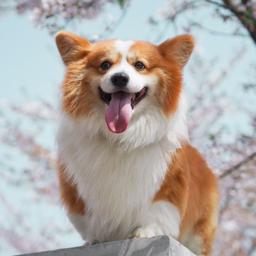

In [13]:
# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
# display(raw_image.resize((596, 437)))
raw_image = Image.open(image_name)
display(raw_image.resize((256, 256)))
text = "dog"

In [14]:
image = vision_processer["eval"](raw_image).unsqueeze(0).to(device)
image.size()

torch.Size([1, 3, 224, 224])

In [15]:
# features = model.extract_features(samples, mode="multimodal")
# features.multimodal_embeds.size()

In [16]:
# model.custom_forward(samples)

### process inputs

In [17]:
def pre_caption(caption,max_words=30):
    caption = re.sub(
        r"([,.'!?\"()*#:;~])",
        '',
        caption.lower(),
    ).replace('-', ' ').replace('/', ' ')

    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n') 
    caption = caption.strip(' ')

    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])            
    return caption

In [18]:
pre_text = pre_caption(text)
pre_text

'dog'

In [19]:
# image = transform(raw_image).unsqueeze(0)  

In [20]:
image.size()

torch.Size([1, 3, 224, 224])

In [21]:
# token_text = model.tokenizer(pre_text, return_tensors='pt')
# token_text

### pass through layers

In [22]:
model.Qformer.base_model.base_model.encoder.layer[8].crossattention.self.save_attention = True
model.Qformer.base_model.base_model.encoder.layer[8].crossattention.self.save_attention

True

In [23]:
samples = {'image': image.to(device), 'text_input': pre_text}
samples

{'image': tensor([[[[0.6749, 0.6019, 0.5873,  ..., 0.6749, 0.8209, 0.7917],
           [0.6603, 0.6603, 0.6895,  ..., 0.4705, 0.5727, 0.6311],
           [0.7041, 0.7479, 0.7771,  ..., 0.3099, 0.3683, 0.4121],
           ...,
           [1.0836, 1.0982, 1.1274,  ..., 0.6603, 0.8355, 0.9376],
           [1.0836, 1.1128, 1.1420,  ..., 0.7479, 0.9084, 0.9814],
           [1.1128, 1.1420, 1.1566,  ..., 0.8063, 0.9230, 0.9814]],
 
          [[0.9343, 0.8593, 0.8442,  ..., 0.9343, 1.0694, 1.0243],
           [0.9493, 0.9643, 0.9793,  ..., 0.6491, 0.7242, 0.7842],
           [1.0243, 1.0694, 1.0994,  ..., 0.3790, 0.4240, 0.4691],
           ...,
           [1.4596, 1.4896, 1.5046,  ..., 0.9193, 1.0994, 1.2044],
           [1.4896, 1.5196, 1.5346,  ..., 1.0694, 1.2344, 1.3245],
           [1.5196, 1.5496, 1.5796,  ..., 1.0994, 1.2645, 1.3395]],
 
          [[1.1932, 1.1221, 1.1078,  ..., 1.1221, 1.2500, 1.2216],
           [1.2074, 1.2074, 1.2358,  ..., 0.8945, 0.9799, 1.0225],
           [1.2

In [24]:
output = model(samples)

In [25]:
loss = output['loss']
loss

tensor(7.7677, device='cuda:0', grad_fn=<AddBackward0>)

In [26]:
text_tokens = model.tokenizer(
    pre_text,
    padding="max_length",
    truncation=True,
    max_length=32,
    return_tensors="pt",
).to(device)

In [27]:
image.size()

torch.Size([1, 3, 224, 224])

In [28]:
model.zero_grad()
loss.backward()

In [29]:
# model.zero_grad()
# loss.backward()    

with torch.no_grad():
    mask = text_tokens.attention_mask.view(text_tokens.attention_mask.size(0),1,-1,1,1)
    
    print("mask shape: ", mask.size())

    # text_encoder here is a pre-trained bert
    grads=model.Qformer.base_model.base_model.encoder.layer[8].crossattention.self.get_attn_gradients()
    # after save, should have cam
    cams=model.Qformer.base_model.base_model.encoder.layer[8].crossattention.self.get_attention_map()
    
    print("grads shape: ", grads.size())
    print("cams shape: ", cams.size())
    
    print("reshaped: ")
    print("grads shape: ", grads[:, :, :, 1:].size())
    print("cams shape: ", cams[:, :, :, 1:].size())
    
    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 16, 16) * mask # 12 for the 12 layers
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 16, 16) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()

mask shape:  torch.Size([1, 1, 32, 1, 1])
grads shape:  torch.Size([1, 12, 32, 257])
cams shape:  torch.Size([1, 12, 32, 257])
reshaped: 
grads shape:  torch.Size([1, 12, 32, 256])
cams shape:  torch.Size([1, 12, 32, 256])


### finally! visualize

In [30]:
def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap


normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((224,224),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     

In [31]:
gradcam[0].size()

torch.Size([16, 16])

In [33]:
mask = gradcam[1].cpu().detach().numpy()

In [34]:
np.mean(mask)

0.08450742

In [37]:
mask[mask < np.mean(mask)] = 1
mask[mask > np.mean(mask)] = 0

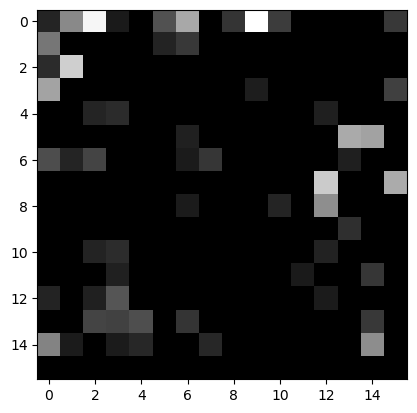

In [38]:
imgplot = plt.imshow(mask, cmap='gray')

In [38]:
!ls ~/blended-latent-diffusion/inputs/

dog_and_cat.jpg  mask.png      mask_cloud.png	mask_grey_cat.png
img.png		 mask_cat.png  mask_flower.png


In [213]:
plt.savefig("../blended-latent-diffusion/inputs/mask_grey_cat.png")

<Figure size 640x480 with 0 Axes>

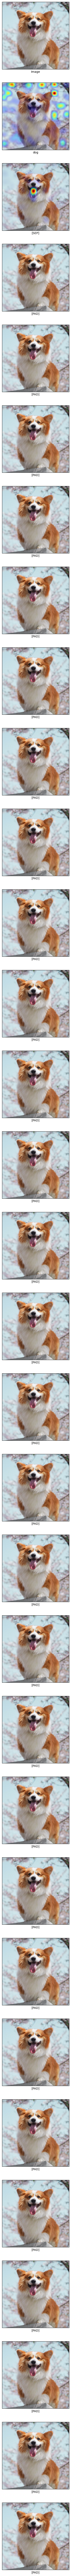

In [32]:
num_image = len(text_tokens.input_ids[0]) 
fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))

rgb_image = cv2.imread(image_name)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

np_gradcam = gradcam.cpu().numpy()

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")
            
for i,token_id in enumerate(text_tokens.input_ids[0][1:]):
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, np_gradcam[i+1], blur=False)
    ax[i+1].imshow(gradcam_image)
    ax[i+1].set_yticks([])
    ax[i+1].set_xticks([])
    ax[i+1].set_xlabel(word)

In [61]:
rgb_image.shape[:2]

(874, 1192)

In [56]:
!ls images

dog_2.jpg  dog_and_cat.jpg  fountain.jpg  rope.jpg  sofa.jpg  two_cats.png
